In [ ]:
!mkdir levels

In [ ]:
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import random
import importlib
import game
import matplotlib.pyplot as plt
importlib.reload(game)
from copy import deepcopy

## Backward Agent

In [ ]:
class BackwardValueNetwork(nn.Module):
    def __init__(self, input_size=5, output_size=1):
        super(BackwardValueNetwork, self).__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 512)
        self.linear3 = nn.Linear(512, 512)
        self.linear4 = nn.Linear(512, output_size)

    def forward(self, state):
        state = self.linear1(state)
        state = self.linear2(state)
        state = self.linear3(state)
        state = self.linear4(state)
        return state


In [ ]:
class BackwardAgent():
    def __init__(self):
        self.value_network = BackwardValueNetwork()
        self.optimizer = optim.Adam(self.value_network.parameters(), lr=0.001)
        self.loss = nn.MSELoss()
        self.gamma = 0.9
        self.alpha = 0.1
        self.discount = 0.98
        self.eps = 0.1
        # TODO: might want to add eps decay here

    # POST: Returns backward trajectory as specified by the paper
    # More precisely returns a list of all board positions visited by the backward agent
    # and the packing order as impled by the backward trajectory
    # TODO: how should the packing order be calulated? For now the packing order is the order in which the boxes leave the goal they start on.
    def backward_trajectory(self, env):
        self.value_network.eval()
        packing_order = []
        positions = [deepcopy(env.box_positions)]

        state, reward, done = env.state(gamma=self.gamma)
        while not done:
            # Choose action
            action, next_state, reward, done = self.choose_action(env)

            # Update game state if action is chosen
            if action is not None:
                state, reward, done = env.play(action, gamma=self.gamma)
                assert next_state == state, "State vector mismatch after action"
                if reward != 0:
                  assert done, "Received reward but did not terminate"

            positions = positions + [deepcopy(env.box_positions)]

            for i in range(len(env.box_positions)):
              if env.box_positions[i][0] != env.goal_positions[i][0] or env.box_positions[i][1] != env.goal_positions[i][1]:
                if not i in packing_order:
                  packing_order.append(i)
        packing_order.reverse()

        return positions, packing_order

    def policy(self, env):
        self.value_network.eval()
        legal_moves = env.legal_moves()
        value_moves = []
        for char in legal_moves:
            state, reward, done = env.step(char, gamma=self.gamma)
            state_tensor = torch.tensor(state)
            value_moves.append([char, state, reward, done, self.value_network(state_tensor)])
        return max(value_moves, key=lambda x:x[4])

    def random_policy(self, env):
      legal_moves = env.legal_moves()
      if len(legal_moves)==0:
        return None
      else:
        return random.choice(legal_moves)

    def random_baseline(self, number_of_episodes, start, end, plot=True):
      wins=[0 for i in range(number_of_episodes)]
      moves=[]
      for episode in tqdm(range(number_of_episodes)):
          # create new game instance
          ind = random.randint(start, end)
          env = game.ReverseGame(game.Game(level_id=ind), disable_prints=True)
          if episode % 100 == 0:
              moves.append(env.player_position)
          state, reward, done = env.state(gamma=self.gamma)
          while not done:
            action = self.random_policy(env)
            if episode % 100 == 0:
              moves.append(action)
            if action != None:
              state, reward, done = env.play(action, gamma=self.gamma)
              wins[episode] = wins[episode] + reward
            else:
              done = 1
      if plot:
        plt.plot([sum(wins[:i])/number_of_episodes for i in range(number_of_episodes)], label="backward random policy")
        plt.legend()
      print(f"backward agent in [{start}, {end}] random policy solved: {sum(wins)/number_of_episodes}, {sum(wins)}/{number_of_episodes}")

    def eval(self, number_of_tries_per_level, start, end):
      for id in range(start, end+1):
        for t in range(number_of_tries_per_level):
          pass

    # The paper originally followed an off policy learning apporach, always updating on the move with the highest reward and sometimes choosing a random action after the TD(0) update
    # This potentially causes learning inefficiencies when random actions end the episode and receive rewards.
    # For this reason we stick to on policy learning for now

    def train(self, number_of_episodes, start, end, plot=True):
      wins = [0 for _ in range(number_of_episodes)]
      moves = []

      for episode in tqdm(range(number_of_episodes)):
          ind = random.randint(start, end)
          # Initialize the game
          env = game.ReverseGame(game.Game(level_id=ind), disable_prints=True)

          if episode % 100 == 0:
              moves.append(env.player_position)

          state, reward, done = env.state(gamma=self.gamma)
          while not done:
              # Choose action
              action, next_state, reward, done = self.choose_action(env)

              # TD(0) update
              self.update_agent(state, next_state, reward, done)

              # Update game state if action is chosen
              if action is not None:
                  state, reward, done = env.play(action, gamma=self.gamma)
                  assert next_state == state, "State vector mismatch after action"
                  if reward != 0:
                    assert done, "Received reward but did not terminate"
              wins[episode] += reward

              if episode % 100 == 0:
                  moves.append(action)

      if plot:
          plt.plot([sum(wins[:i])/number_of_episodes for i in range(number_of_episodes)], label="backward greedy policy")
          plt.legend()
          file_path = "backward_run.json"
          json_data = json.dumps(moves)
          with open(file_path, "w") as file:
              file.write(json_data)
      print(f"backward agent in [{start}, {end}] greedy policy solved: {sum(wins)/number_of_episodes}, {sum(wins)}/{number_of_episodes}")

      # return wins, moves

    def choose_action(self, env):
      action, next_state, next_reward, next_done = None, None, None, None
      legal_moves = env.legal_moves()
      # agent is stuck and can't move
      if len(legal_moves) == 0:
        next_state, next_reward, next_done = env.state(gamma=self.gamma)
        next_done=1
      # exploration
      elif np.random.rand() < self.eps:
        action = random.choice(legal_moves)
        next_state, next_reward, next_done = env.step(action, gamma=self.gamma)
      # exploitation
      else:
        [action, next_state, next_reward, next_done, _] = self.policy(env)
      return action, next_state, next_reward, next_done

    def update_agent(self, state, next_state, reward, done):
      self.value_network.train()
      state_tensor = torch.tensor(state)
      next_state_tensor = torch.tensor(next_state)
      value = self.value_network(state_tensor)
      next_value = self.value_network(next_state_tensor)
      # TD(0) update: V(s)←V(s)+α(R+γV(s')−V(s))
      target = value + self.alpha*(reward + self.gamma*next_value*(1-done) - value)
      # calculate loss
      loss = self.loss(value, target.detach()) # using detach here to exclude prediction from computation graph as is standard in TD(0)
      # optimize
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()



### Tests

100%|██████████| 100/100 [00:03<00:00, 31.17it/s]


backward agent in [0, 0] greedy policy solved: 1.0, 100/100


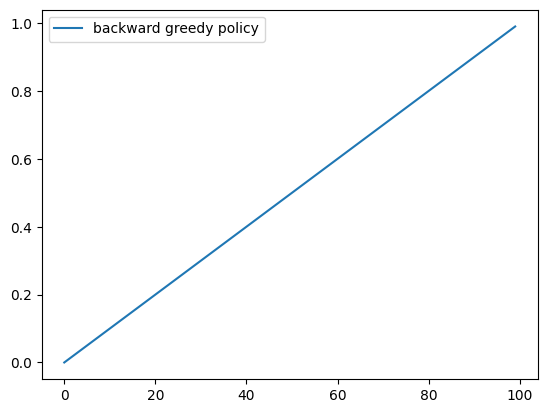

In [ ]:
torch.manual_seed(40)
random.seed(40)
np.random.seed(40)
backwardagent = BackwardAgent()
backwardagent.train(number_of_episodes=100, start=0, end=0)

In [ ]:
for i in range(5):
  print(f"{i}:")
  backwardagent = BackwardAgent()
  backwardagent.train(number_of_episodes=100, start=9, end=9, plot=False)
  backwardagent.random_baseline(number_of_episodes=100, start=9, end=9, plot=False)

0:


100%|██████████| 100/100 [00:09<00:00, 10.43it/s]


backward agent in [9, 9] greedy policy solved: 1.0, 100/100


100%|██████████| 100/100 [00:01<00:00, 82.35it/s]


backward agent in [9, 9] random policy solved: 0.7, 70/100
1:


100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


backward agent in [9, 9] greedy policy solved: 0.8, 80/100


100%|██████████| 100/100 [00:02<00:00, 49.74it/s]


backward agent in [9, 9] random policy solved: 0.75, 75/100
2:


100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


backward agent in [9, 9] greedy policy solved: 0.81, 81/100


100%|██████████| 100/100 [00:01<00:00, 67.08it/s]


backward agent in [9, 9] random policy solved: 0.7, 70/100
3:


100%|██████████| 100/100 [00:07<00:00, 12.88it/s]


backward agent in [9, 9] greedy policy solved: 0.96, 96/100


100%|██████████| 100/100 [00:01<00:00, 72.31it/s]


backward agent in [9, 9] random policy solved: 0.73, 73/100
4:


100%|██████████| 100/100 [00:07<00:00, 14.22it/s]


backward agent in [9, 9] greedy policy solved: 0.99, 99/100


100%|██████████| 100/100 [00:01<00:00, 79.40it/s]

backward agent in [9, 9] random policy solved: 0.67, 67/100


100%|██████████| 400/400 [00:30<00:00, 13.20it/s]


backward agent in [1, 1] greedy policy solved: 0.8875, 355/400
[[[1, 2], [3, 1]], [[1, 2], [3, 1]], [[1, 2], [3, 1]], [[1, 2], [3, 1]], [[1, 2], [3, 1]], [[2, 2], [3, 1]], [[3, 2], [3, 1]], [[3, 2], [3, 1]], [[3, 2], [3, 1]], [[3, 2], [3, 1]], [[3, 2], [3, 1]], [[3, 2], [3, 1]], [[3, 2], [3, 1]], [[3, 2], [3, 1]], [[3, 2], [3, 1]], [[4, 2], [3, 1]], [[4, 2], [3, 1]], [[4, 2], [3, 1]], [[4, 2], [4, 1]]]
packing order: [0, 1]


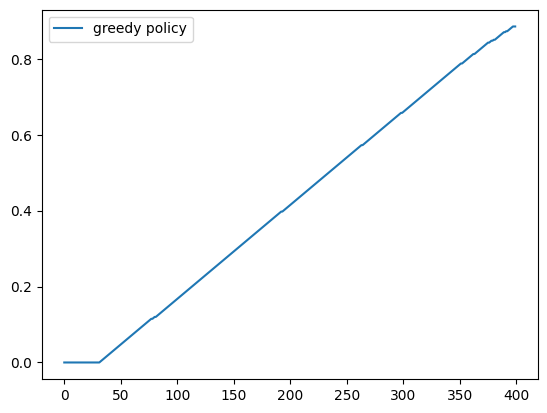

In [ ]:
# TODO: seems like the agent smetimes is just one move away from winning but instead runs back and forth
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
backwardagent = BackwardAgent()
backwardagent.train(number_of_episodes=400, start=1, end=1)
env = game.ReverseGame(game.Game(level_id=1), disable_prints=True)
trajectory, packing_order = backwardagent.backward_trajectory(env)
print(trajectory)
print(f"packing order: {packing_order}")

## Forward Agent

In [ ]:
class ForwardValueNetwork(nn.Module):
    def __init__(self, input_size=5 + 2, output_size=1):
        super(ForwardValueNetwork, self).__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 512)
        self.linear3 = nn.Linear(512, 512)
        self.linear4 = nn.Linear(512, output_size)

    def forward(self, state):
        state = self.linear1(state)
        state = self.linear2(state)
        state = self.linear3(state)
        state = self.linear4(state)
        return state

In [ ]:
class ForwardAgent():
  def __init__(self):
    self.value_network = ForwardValueNetwork()
    self.optimizer = optim.Adam(self.value_network.parameters(), lr=0.001)
    self.loss = nn.MSELoss()
    self.gamma = 0.9
    self.alpha = 0.1
    self.discount = 0.97
    self.initial_eps = 1
    self.eps = self.initial_eps
    self.minimal_eps = 0.1
    self.eps_decay = 0.92
    self.current_packing_order = []
    self.backwardagent = BackwardAgent()
    self.backwardagent.value_network.eval()

  def overlap(self, box_positions, trajectory):
    # TODO: make this more efficient exploting previous overlap calculation
    box_position = [[1,2], [3,2]]
    trajectory = [[[1,2], [3,2]], [[4, 1], [1,2]], [[0,1],[9,1]]]
    set_box_positions = set(map(tuple, box_positions))
    overlap = [len(set_box_positions.intersection(set(map(tuple, hist)))) for hist in trajectory]
    return max(overlap)

  def perm(self, box_positions, packing_order, env):
    # TODO: Think about what should happen in the case that a box gets pushed on and off a goal
    # TODO: what should happen with boxes that have not been pulled off the goals by the backward agent (backwardagent did not solve the task)
    goal_positions = env.goal_positions
    for i, box_position in enumerate(box_positions):
      if box_position in goal_positions:
        if i not in self.current_packing_order:
          self.current_packing_order.append(i)
    perm = [packing_order[i] == self.current_packing_order[i] for i in range(min(len(self.current_packing_order), len(packing_order)))]
    return sum(perm)


  def policy(self, env, packing_order, trajectory):
    self.value_network.eval()
    legal_moves = env.legal_moves()
    assert len(legal_moves), "agent is stuck"
    value_moves = []
    for char in legal_moves:
        box_positions, state, reward, done = env.step(char, gamma=self.gamma)
        feature = self.update_feature_vector(state, box_positions, packing_order, trajectory, env)
        feature_tensor = torch.tensor(feature)
        value_moves.append([char, feature, reward, done, self.value_network(feature_tensor)])
    return max(value_moves, key=lambda x:x[4])

  def random_policy(self, env):
    legal_moves = env.legal_moves()
    if len(legal_moves)==0:
      return None
    else:
      return random.choice(legal_moves)

  def random_baseline(self, number_of_episodes, start, end, plot=True):
    wins=[0 for i in range(number_of_episodes)]
    moves=[]
    for episode in tqdm(range(number_of_episodes)):
        # create new game instance
        ind = random.randint(start, end)
        env = game.Game(level_id=ind, disable_prints=True)
        if episode % 100 == 0:
            moves.append(env.player_position)
        _, state, reward, done = env.state(gamma=self.gamma)
        while not done:
          action = self.random_policy(env)
          if episode % 100 == 0:
            moves.append(action)
          if action != None:
            _, state, reward, done = env.play(action, gamma=self.gamma)
            wins[episode] = wins[episode] + reward
          else:
            done = 1
    if plot:
      plt.plot([sum(wins[:i])/number_of_episodes for i in range(number_of_episodes)], label="forward random policy")
      plt.legend()
    print(f"forward agent in [{start}, {end}] random policy solved: {sum(wins)/number_of_episodes}, {sum(wins)}/{number_of_episodes}")

  def train_backward_agent(self, number_of_episodes, start, end):
      self.backwardagent.value_network.train()
      self.backwardagent.train(number_of_episodes=number_of_episodes, start=start, end=end, plot=False)
      self.backwardagent.value_network.eval()

  def train(self, number_of_episodes, start, end, plot=True):
      wins = [0 for _ in range(number_of_episodes)]
      moves = []

      for episode in tqdm(range(number_of_episodes)):
          if self.eps > self.minimal_eps:
            self.eps = self.eps * self.eps_decay
          self.eps=0.2
          ind = random.randint(start, end)
          # Initialize the game
          reverse = game.ReverseGame(game.Game(level_id=ind), disable_prints=True)
          # TODO: here i think it only makes sense for the agent to start in a specific position, not really if it starts in a random spot
          trajectory, packing_order = self.backwardagent.backward_trajectory(reverse)
          env = game.Game(level_id=ind, disable_prints=True)

          if episode % 100 == 0:
              moves.append(env.player_position)

          box_positions, state, reward, done = env.state(gamma=self.gamma)
          feature = self.update_feature_vector(state, box_positions, packing_order, trajectory, env)
          while not done:
              # Choose action
              action, next_feature, reward, done = self.choose_action(env, packing_order, trajectory)

              # TD(0) update
              self.update_agent(feature, next_feature, reward, done)

              # Update game state if action is chosen
              if action is not None:
                  box_positions, state, reward, done = env.play(action, gamma=self.gamma)
                  expected_feature = self.update_feature_vector(state, box_positions, packing_order, trajectory, env)
                  assert next_feature == expected_feature, "Feature vector mismatch after action"
                  if reward != 0:
                    assert done, "Received reward but did not terminate"
              wins[episode] += reward
              feature = next_feature

              if episode % 100 == 0:
                  moves.append(action)

      if plot:
          #plt.plot([sum(wins[:i])/number_of_episodes for i in range(number_of_episodes)], label="forward greedy policy")
          plt.scatter([i for i in range(len(wins))], wins, label="forward greedy policy")
          plt.legend()
          file_path = "forward_run.json"
          json_data = json.dumps(moves)
          with open(file_path, "w") as file:
              file.write(json_data)

      print(f"forward agent in [{start}, {end}] greedy policy solved: {sum(wins)/number_of_episodes}, {sum(wins)}/{number_of_episodes}")
      # return wins, moves

  def choose_action(self, env, packing_order, trajectory):
    action, next_feature, next_reward, next_done = None, None, None, None
    legal_moves = env.legal_moves()
    # agent is stuck and can't move
    if len(legal_moves) == 0:
      next_box_positions, next_state, next_reward, next_done = env.state(gamma=self.gamma)
      next_done=1
      next_feature = self.update_feature_vector(next_state, next_box_positions, packing_order, trajectory)
    # exploration
    elif np.random.rand() < self.eps:
      action = random.choice(legal_moves)
      next_box_positions, next_state, next_reward, next_done = env.step(action, gamma=self.gamma)
      next_feature = self.update_feature_vector(next_state, next_box_positions, packing_order, trajectory, env)
    # exploitation
    else:
      [action, next_feature, next_reward, next_done, _] = self.policy(env, packing_order=packing_order, trajectory=trajectory)
    return action, next_feature, next_reward, next_done
  def update_feature_vector(self, state, box_positions, packing_order, trajectory, env):
    return state + [self.perm(box_positions=box_positions, packing_order=packing_order, env=env)] + [self.overlap(box_positions=box_positions, trajectory=trajectory)]

  def update_agent(self, feature, next_feature, reward, done):
    feature_tensor = torch.tensor(feature)
    next_feature_tensor = torch.tensor(next_feature)
    value = self.value_network(feature_tensor)
    next_value = self.value_network(next_feature_tensor)
    # TD(0) update: V(s)←V(s)+α(R+γV(s')−V(s))
    target = value + self.alpha*(reward + self.gamma*next_value.detach()*(1-done) - value) # using detach here to exclude prediction from computation graph as is standard in TD(0)
    # calculate loss
    loss = self.loss(value, target.detach())
    # optimize
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()



100%|██████████| 100/100 [00:13<00:00,  7.63it/s]


forward agent in [0, 0] greedy policy solved: 1.0, 100/100


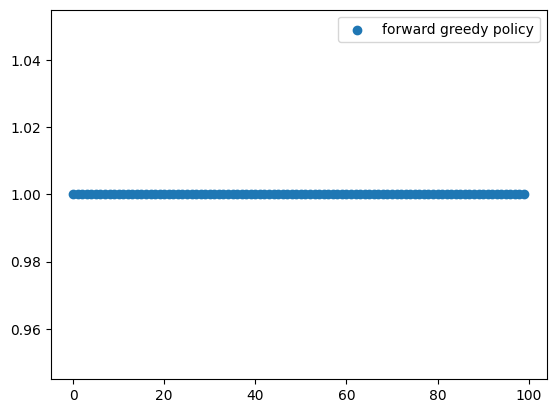

In [ ]:
torch.manual_seed(40)
random.seed(40)
np.random.seed(40)
forwardagent = ForwardAgent()
# forwardagent.train_backward_agent(number_of_episodes=20,start=9,end=9)
forwardagent.train(number_of_episodes=100, start=0, end=0)

i: 0


100%|██████████| 12/12 [00:02<00:00,  5.43it/s]


backward agent in [0, 0] greedy policy solved: 0.9166666666666666, 11/12


100%|██████████| 12/12 [00:02<00:00,  5.91it/s]


forward agent in [0, 0] greedy policy solved: 0.9166666666666666, 11/12


100%|██████████| 25/25 [00:04<00:00,  5.46it/s]


backward agent in [9, 9] greedy policy solved: 0.68, 17/25


100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


forward agent in [9, 9] greedy policy solved: 0.0, 0/100
i: 1


100%|██████████| 12/12 [00:00<00:00, 12.08it/s]


backward agent in [0, 0] greedy policy solved: 1.0, 12/12


100%|██████████| 12/12 [00:01<00:00,  7.36it/s]


forward agent in [0, 0] greedy policy solved: 1.0, 12/12


100%|██████████| 25/25 [00:02<00:00,  8.36it/s]


backward agent in [9, 9] greedy policy solved: 0.92, 23/25


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


forward agent in [9, 9] greedy policy solved: 0.0, 0/100
i: 2


100%|██████████| 12/12 [00:00<00:00, 12.52it/s]


backward agent in [0, 0] greedy policy solved: 0.9166666666666666, 11/12


100%|██████████| 12/12 [00:01<00:00,  6.39it/s]


forward agent in [0, 0] greedy policy solved: 1.0, 12/12


100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


backward agent in [9, 9] greedy policy solved: 0.84, 21/25


100%|██████████| 100/100 [01:14<00:00,  1.33it/s]


forward agent in [9, 9] greedy policy solved: 0.0, 0/100


100%|██████████| 100/100 [00:05<00:00, 19.77it/s]


forward agent in [9, 9] random policy solved: 0.0, 0/100


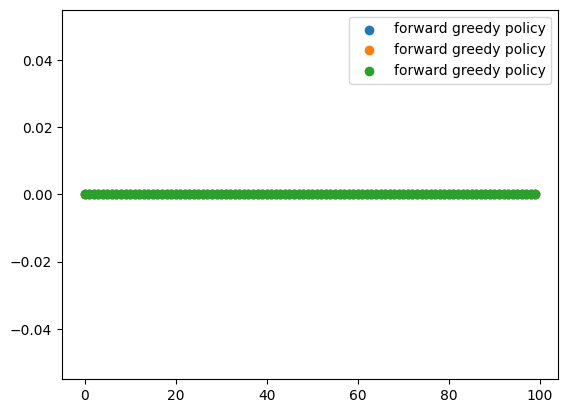

In [ ]:
# TODO: it seems like if the agent does not find the goal in the first iteration, its value function converges to a undesirable stationary function
torch.manual_seed(40)
random.seed(40)
np.random.seed(40)
for i in range(3):
  print(f"i: {i}")
  forwardagent = ForwardAgent()
  forwardagent.train_backward_agent(number_of_episodes=12, start=0, end=0)
  forwardagent.train(number_of_episodes=12, start=0, end=0, plot=False)
  forwardagent.train_backward_agent(number_of_episodes=25, start=9, end=9)
  forwardagent.train(number_of_episodes=100, start=9, end=9)
baseline = ForwardAgent()
baseline.random_baseline(number_of_episodes=100, start=9, end=9, plot=False)